# Survival analysis lab


Jorge Parreño Hernández - 100429982

Riccardo Conforto Galli

Filippo Nardi



#### Instructions



Do some exploratory analysis to design the patient's features to be used. What features are missing, which do not seem to correlate with the survival time, and what groups of features are jointly correlated.

Given the set of features, run some clustering algorithms to separate the patients into groups. You can use Kmeans, DBScan, or any other. Clustering can be done over the input feature or a reduced space using PCA or a VAE.

Compute the survival function for each group using Kaplan-Meier and Cox Regression. Analyze the differences between both methods and the survival differences between groups. In terms of interpretability, recall that Cox provides a feature importance.

Summarize everything in a one-page report with a link to your code (use Google Drive or Github).

You can work individually or in groups of up to three people. This lab counts up to 1.25 points in the overall grade.
The deadline is 15th December.

Have fun!

### Loading data

Loading data, checking for missing values

In [1]:
! pip install -r requirements.txt

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/bin/pip: 2: exec: /home/jorge/Desktop/Data science/4/MLH/venv/bin/python: not found


In [2]:
! pip install ucimlrepo

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/bin/pip: 2: exec: /home/jorge/Desktop/Data science/4/MLH/venv/bin/python: not found


In [3]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd 
# fetch dataset 
bone_marrow_transplant_children = fetch_ucirepo(id=565) 
  
# data (as pandas dataframes) 
X = bone_marrow_transplant_children.data.features 
y = bone_marrow_transplant_children.data.targets 
  
# metadata 
print(bone_marrow_transplant_children.metadata) 
  
# variable information 
print(bone_marrow_transplant_children.variables) 


{'uci_id': 565, 'name': 'Bone marrow transplant: children', 'repository_url': 'https://archive.ics.uci.edu/dataset/565/bone+marrow+transplant+children', 'data_url': 'https://archive.ics.uci.edu/static/public/565/data.csv', 'abstract': 'The data set describes pediatric patients with several hematologic diseases, who were subject to the unmanipulated allogeneic unrelated donor hematopoietic stem cell transplantation.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 187, 'num_features': 36, 'feature_types': ['Integer', 'Real'], 'demographics': ['Gender', 'Age'], 'target_col': ['survival_status'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5NP6Z', 'creators': ['Marek Sikora', 'Łukasz Wróbel', 'Adam Gudyś'], 'intro_paper': {'title': 'GuideR: a guided separate-and-conquer rule learn

Now we display the number of missing values per column in the dataset

In [4]:
mFeatures = X.isna()
mTargets = y.isna()
print(f"Missing features :\n{mFeatures.sum()}")
# print(f"Missing targets: {mTargets.sum()}") 0

Missing features :
Recipientgender          0
Stemcellsource           0
Donorage                 0
Donorage35               0
IIIV                     0
Gendermatch              0
DonorABO                 0
RecipientABO             1
RecipientRh              2
ABOmatch                 1
CMVstatus               16
DonorCMV                 2
RecipientCMV            14
Disease                  0
Riskgroup                0
Txpostrelapse            0
Diseasegroup             0
HLAmatch                 0
HLAmismatch              0
Antigen                  1
Allele                   1
HLAgrI                   0
Recipientage             0
Recipientage10           0
Recipientageint          0
Relapse                  0
aGvHDIIIIV               0
extcGvHD                31
CD34kgx10d6              0
CD3dCD34                 5
CD3dkgx10d8              5
Rbodymass                2
ANCrecovery              0
PLTrecovery              0
time_to_aGvHD_III_IV     0
survival_time            0
dtype: in

In [5]:

# Calculate the total number of instances with missing values for features
tmFeatures = mFeatures.any(axis=1).sum()
print(f"Total instances with missing features: {round(tmFeatures/len(X) * 100, 2)}%")

Total instances with missing features: 24.06%


In [6]:
X.describe()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,186.000000,185.000000,186.000000,...,187.000000,156.000000,187.000000,182.000000,182.000000,185.000000,187.000000,187.000000,187.000000,187.000000
mean,0.598930,0.775401,33.472068,0.443850,0.598930,0.171123,0.390374,0.274194,0.854054,0.720430,...,0.786096,0.820513,11.891781,5.385096,4.745714,35.801081,26752.866310,90937.919786,775408.042781,938.743316
std,0.491431,0.418438,8.271826,0.498171,0.491431,0.377627,0.837632,0.938706,0.354010,0.449999,...,0.411161,0.384996,9.914386,9.598716,3.859128,19.650922,161747.200525,288242.407688,418425.252689,849.589495
min,0.000000,0.000000,18.646575,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,...,0.000000,0.000000,0.790000,0.204132,0.040000,6.000000,9.000000,9.000000,10.000000,6.000000
25%,0.000000,1.000000,27.039726,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,...,1.000000,1.000000,5.350000,1.786683,1.687500,19.000000,13.000000,16.000000,1000000.000000,168.500000
50%,1.000000,1.000000,33.550685,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,9.720000,2.734462,4.325000,33.000000,15.000000,21.000000,1000000.000000,676.000000
75%,1.000000,1.000000,40.117809,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,15.415000,5.823565,6.785000,50.600000,17.000000,37.000000,1000000.000000,1604.000000
max,1.000000,1.000000,55.553425,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,57.780000,99.560970,20.020000,103.400000,1000000.000000,1000000.000000,1000000.000000,3364.000000


In [7]:
missing = X.isna().any()
# Check data types of columns with missing values, checking that the columns where there are missing values are all numeric
for column_name, has_missing in missing.items():
    if has_missing:
        data_type = X[column_name].dtype
        print(f"Column '{column_name}' is {'numeric' if pd.api.types.is_numeric_dtype(data_type) else 'string'}")

Column 'RecipientABO' is numeric
Column 'RecipientRh' is numeric
Column 'ABOmatch' is numeric
Column 'CMVstatus' is numeric
Column 'DonorCMV' is numeric
Column 'RecipientCMV' is numeric
Column 'Antigen' is numeric
Column 'Allele' is numeric
Column 'extcGvHD' is numeric
Column 'CD3dCD34' is numeric
Column 'CD3dkgx10d8' is numeric
Column 'Rbodymass' is numeric


We observe a non-negligible number of incomplete instances and thus simply removing them is not an option we therefore need to impute. We import custom RNN imputer class

In [8]:
from utils import RNNAutoImputer

# select columns with missing values
miscols = X.columns[missing].tolist()
subset = X[miscols]
imputer = RNNAutoImputer(rnn_units=1024)

# Trains the RNN, run on 10th gen i5 locally takes ~ 2m 40 seconds 
imputedSubset = imputer.impute(subset)



2023-11-16 19:42:33.358404: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:42:33.513579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 19:42:33.513613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 19:42:33.514522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 19:42:33.576098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:42:33.577406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Epoch 1/30
6/6 [==============================] - 4s 290ms/step - loss: 123.6454
Epoch 2/30
6/6 [==============================] - 2s 302ms/step - loss: 88.5937
Epoch 3/30
6/6 [==============================] - 2s 290ms/step - loss: 70.8764
Epoch 4/30
6/6 [==============================] - 2s 273ms/step - loss: 55.3837
Epoch 5/30
6/6 [==============================] - 2s 268ms/step - loss: 43.1911
Epoch 6/30
6/6 [==============================] - 2s 274ms/step - loss: 30.4450
Epoch 7/30
6/6 [==============================] - 2s 264ms/step - loss: 22.6909
Epoch 8/30
6/6 [==============================] - 2s 256ms/step - loss: 16.6459
Epoch 9/30
6/6 [==============================] - 2s 253ms/step - loss: 12.2466
Epoch 10/30
6/6 [==============================] - 2s 256ms/step - loss: 9.3391
Epoch 11/30
6/6 [==============================] - 2s 255ms/step - loss: 7.3023
Epoch 12/30
6/6 [==============================] - 2s 256ms/step - loss: 5.7149
Epoch 13/30
6/6 [======================

Now we update the column subset with missing values

In [9]:
X[miscols]=imputedSubset
bone_marrow_transplant_children.features = X

/tmp/ipykernel_8844/362839367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[miscols]=imputedSubset


#### Embeddings on string attributes

For clustering the patients into subgroups for the survival analysis, we need to compute contextual embeddings of the string features so that they can be processed by the clustering algorithms, or simply leave them out.

### Clustering patients

To perform clustering, and due to the high dimensionality of the data, we are going to use UMAP (Uniform Manifold Approximation and Projection) to reduce dimensionality and then cluster.
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

1. The data is uniformly distributed on Riemannian manifold;

2. The Riemannian metric is locally constant (or can be approximated as such);

3. The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.


In [10]:
! pip install umap-learn
! pip install hdbscan

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/bin/pip: 2: exec: /home/jorge/Desktop/Data science/4/MLH/venv/bin/python: not found


/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/bin/pip: 2: exec: /home/jorge/Desktop/Data science/4/MLH/venv/bin/python: not found


In [11]:
import umap

# run clustering on this
sbset = X.iloc[:, X.columns!= 'survival_time']

# concat with this for the 
times = X.iloc[:, X.columns == 'survival_time']

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# take out disease column
nodis = sbset.iloc[: , sbset.columns != 'Disease']
disease = sbset.iloc[:, sbset.columns == 'Disease']

In [13]:
ncomp = 4
umodel = umap.UMAP(n_components=ncomp)
umres = umodel.fit_transform(nodis)

# reduced data
rdata = pd.DataFrame(data=umres, columns=[f"UMAP {i}" for i in range(ncomp)])
fdata = pd.concat([rdata,disease, times])

In [14]:
# now we run clustering in the algorithm, we use GMMs
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def bic_val(data, K_list, verbose=False):
    lowest_bic = float('inf')  # Initialize the lowest BIC value as positive infinity
    best_k = 0  # Initialize the best K value as 0
    bics = []
    for k in K_list:
        model = GMM(n_components=k, covariance_type='full', random_state=42)
        model.fit(data)
        bic = model.bic(data)
        bics.append(bic)

        if bic < lowest_bic:
            lowest_bic = bic
            best_k = k
    if verbose: 
        # Create a plot
        plt.figure(figsize=(8, 6))
        plt.plot(K_list, bics, marker='o')
        plt.title("BIC vs. Number of Components (K)")
        plt.xlabel("Number of Components (K)")
        plt.ylabel("BIC Value")
        plt.grid(True)
        plt.show()

    return best_k, lowest_bic

In [15]:
bestk, _ = bic_val(rdata, [i for i in range(1,11)])
model = GMM(n_components=bestk, covariance_type='full', random_state=42)
scaler = StandardScaler()
scaled = scaler.fit_transform(rdata)
model.fit(scaled)
# getting clustering labels from GMM
labels = model.predict(scaled)
X['clustered group'] = labels

### Kaplan - Meier





The Kaplan-Meier estimator, also known as the Product-Limit estimator, is a non-parametric statistic used to estimate the survival function of time-to-event data, especially in medical and biological research. It provides a way to estimate the probability that an event of interest (e.g., death, failure, or event occurrence) will happen at or before a specific time.

##### Basics of Survival Analysis

Survival analysis is often used when dealing with censored data, where we don't know the exact event times for all individuals in a study. Instead, we only have partial information, which can be in one of three states:

1. An observed event has occurred.
2. The event has not yet occurred, but the subject is still under observation.
3. The event has not occurred, and the subject has left the study (censored).

##### Kaplan-Meier Estimator Formula

The Kaplan-Meier estimator is based on the product of conditional survival probabilities over time. The survival function, denoted as S(t), is defined as the probability that the event of interest has not occurred by time t. The formula for the Kaplan-Meier estimator is as follows:

$$
\hat{S}(t) = \prod_{i: t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
$$

Where:
- $\hat{S}(t)$ is the estimated survival probability at time t.
- $t_i$ represents the observed event times.
- $d_i$ is the number of observed events at time $t_i$.
- $n_i$ is the number of subjects at risk (not censored) just before time $t_i$.


This model is basic and weak since it does not account for patient features, it constitutes however a good starting point.

##### Interpreting the Kaplan-Meier Curve

- The shape of the curve reflects the survival experience of the study population.
- Steps or drops in the curve occur when events (deaths or failures) happen.
- The curve may reach 0 (complete failure) if all subjects experience the event.

Now we import the necessary library, sort the dataset based on survival times and fit the Kaplan-Meier for different values of the clustered groups found through GMM

In [16]:
import kaplanmeier as km

df = pd.DataFrame(X, columns = bone_marrow_transplant_children.columns)
df['Survival_status'] = y
df2 = df.sort_values(by='survival_time') # values need to be sorted by survival time

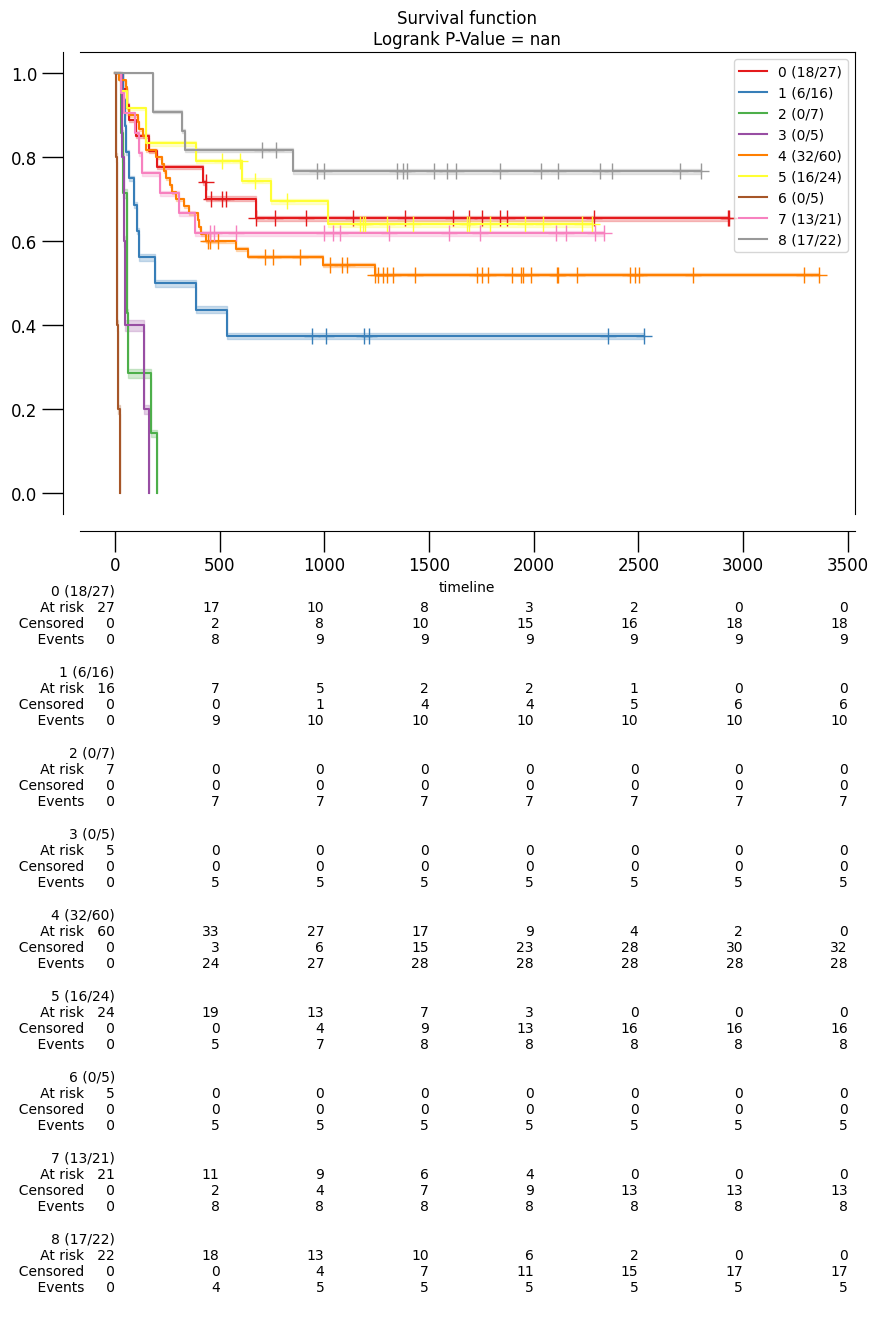

In [17]:
times = df2['survival_time']
censoring = df2['Survival_status'] # survival status is censored
y = df2['clustered group'] # compute Kaplan-Meier curve for different diseases
results = km.fit(times, censoring, y)
km.plot(results)

### Cox-Hazard model

In [18]:
! pip install lifelines 

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/bin/pip: 2: exec: /home/jorge/Desktop/Data science/4/MLH/venv/bin/python: not found


In [69]:
# this columns need to be removed because they completely determine whether a subject dies or not, and causes a convergence error
pcs = ['Diseasegroup', 'ANCrecovery', 'PLTrecovery']
df3 = df2.iloc[:, df2.columns != 'Disease']
for col in pcs:
    df3 = df3.iloc[:, df3.columns != col]

In [68]:
y

181    6
131    6
58     6
137    6
63     4
      ..
5      8
51     0
144    0
15     4
159    4
Name: clustered group, Length: 187, dtype: int64

In [70]:
df3['clustered group'].unique()

array([6, 4, 2, 5, 7, 3, 0, 1, 8])

/home/jorge/Desktop/Data science/4/MLH/ML-in-healthcare/Lab 2/survivalLab/venv/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 699.463. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


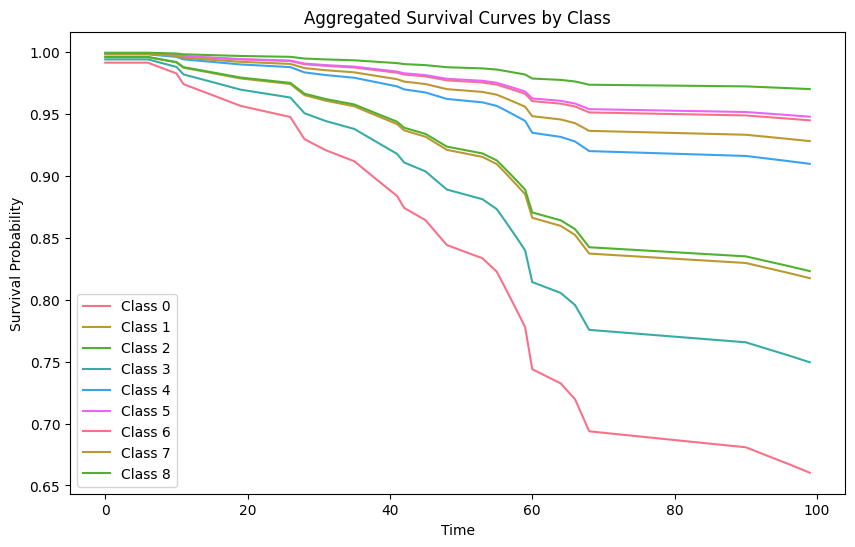

In [74]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns


# Fit a Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df3, duration_col='survival_time', event_col='Survival_status')

# Choose a time range for the survival curve
time_range = range(0, 100)


# Plot aggregated survival curves for each class
plt.figure(figsize=(10, 6))
sns.set_palette("husl")  # You can choose a different color palette

for class_label in sorted(df3['clustered group'].unique()):
    subset_data = df3[df3['clustered group'] == class_label]
    survival_curves = cph.predict_survival_function(subset_data, times=time_range)
    
    # Aggregate survival curves by taking the median, to address shape mismatch
    aggregated_curve = survival_curves.median(axis=1)
    
    plt.plot(aggregated_curve.index, aggregated_curve.values, label=f'Class {class_label}')

# Customize the plot
plt.title('Aggregated Survival Curves by Class')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()